# Brain Tumor Classification with Fine-Tuned Transfer Learning Models
In this project, we will be classifying different types of brain tumors using a deep learning model. We will specifically be using the Vision Transformer Model to classify these images. The code for this experiment was taken from [here](https://www.kaggle.com/raufmomin/vision-transformer-vit-fine-tuning). 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.5.0


In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 7

TRAIN_PATH = '/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/Training'
TEST_PATH = '/content/drive/My Drive/Colab Notebooks/brain_tumor_mri/Testing'

TEST_IMAGES = glob.glob(TEST_PATH + '/*.jpg')

classes = {0 : "Glioma Tumor",
           1 : "Meningioma Tumor",
           2 : "No Tumor",
           3 : "Pituitary Tumor"
           }

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.2,
                                                          preprocessing_function = preprocess_input)

train_gen = datagen.flow_from_directory(directory = TRAIN_PATH,
                                        subset = 'training',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

valid_gen = datagen.flow_from_directory(directory = TRAIN_PATH,
                                        subset = 'validation',
                                        batch_size = BATCH_SIZE,
                                        seed = 1,
                                        color_mode = 'rgb',
                                        shuffle = False,
                                        class_mode = 'categorical',
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE))

test_gen = datagen.flow_from_directory(directory = TEST_PATH, 
                                       batch_size = BATCH_SIZE,
                                       seed = 1,
                                       color_mode = 'rgb',
                                       shuffle = False,
                                       class_mode = None,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

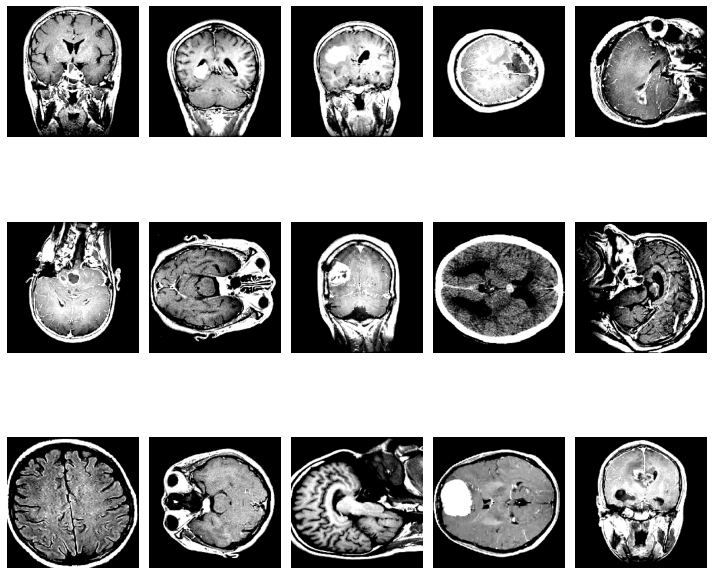

In [ ]:
images = [train_gen[0][0][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(IMAGE_SIZE, IMAGE_SIZE, 3))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
resnet_model = ResNet50(weights='imagenet',
                 include_top=False,
                 classes=4,
                 input_shape=(224, 224, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [7]:
model = tf.keras.Sequential([
        resnet_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = 'softmax'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'resnet')

model.summary()

Model: "resnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100352)            401408    
_________________________________________________________________
dense (Dense)                (None, 11)                1103883   
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 48        
Total params: 25,093,095
Trainable params: 24,839,249
Non-trainable params: 253,846
__________________________________________

In [9]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

model.save('model.h5')

Epoch 1/7
143/143 [==============================] - 2056s 14s/step - loss: 0.9678 - accuracy: 0.7786 - val_loss: 1.5660 - val_accuracy: 0.2804

Epoch 00001: val_accuracy improved from -inf to 0.28036, saving model to ./model.hdf5
Epoch 2/7
143/143 [==============================] - 1699s 12s/step - loss: 0.8674 - accuracy: 0.8702 - val_loss: 1.6315 - val_accuracy: 0.2089

Epoch 00002: val_accuracy did not improve from 0.28036
Epoch 3/7
143/143 [==============================] - 1690s 12s/step - loss: 0.8582 - accuracy: 0.8808 - val_loss: 1.9735 - val_accuracy: 0.3696

Epoch 00003: val_accuracy improved from 0.28036 to 0.36964, saving model to ./model.hdf5
Epoch 4/7
143/143 [==============================] - 1706s 12s/step - loss: 0.8489 - accuracy: 0.8982 - val_loss: 1.2351 - val_accuracy: 0.6250

Epoch 00004: val_accuracy improved from 0.36964 to 0.62500, saving model to ./model.hdf5
Epoch 5/7
143/143 [==============================] - 1687s 12s/step - loss: 0.8261 - accuracy: 0.9066

TypeError: ignored

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       165
           1       0.70      0.80      0.75       164
           2       0.92      0.92      0.92        79
           3       0.78      0.83      0.81       165

    accuracy                           0.82       573
   macro avg       0.85      0.83      0.84       573
weighted avg       0.83      0.82      0.82       573



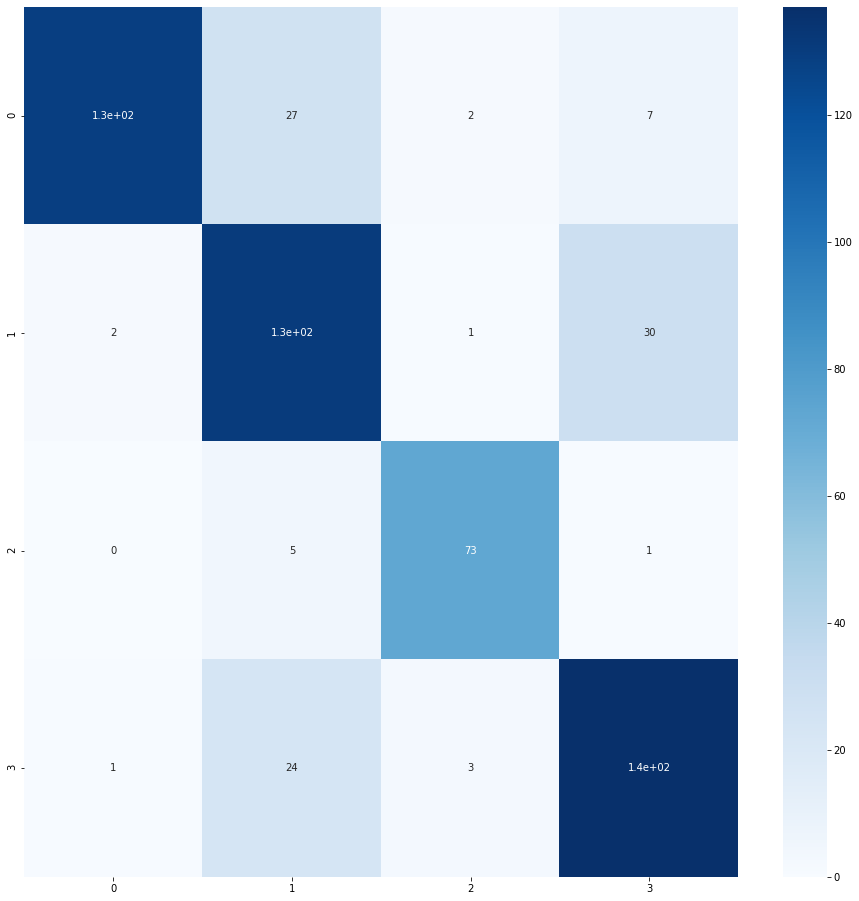

In [10]:
predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(true_classes, predicted_classes))